In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import ase
import matplotlib.pyplot as plt
import numpy as np

import abtem

(walkthrough:scan_and_detect)=
# Scan and detect
Scanning imaging modes such as STEM work by rastering a focused electron probe across the sample pixel by pixel, and recording the scattering signal for each position. To simulate this we have to perform a multislice simulation for every probe position.

## Scanned multislice

We start by creating a model of MoS<sub>2</sub>, whose unit cell we repeat to accomodate the size of the probe wave function (see our [multislice walkthrough](multislice.ipynb)).

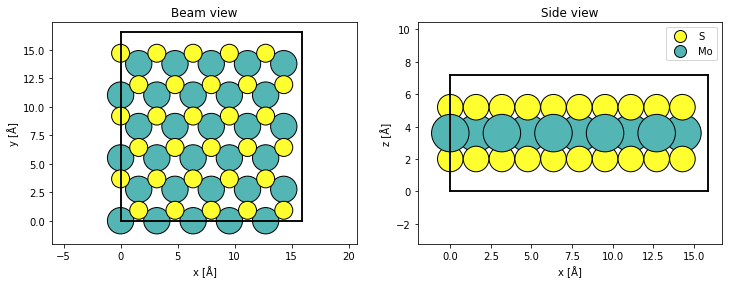

In [2]:
atoms = ase.build.mx2(vacuum=2)

atoms = abtem.orthogonalize_cell(atoms)

atoms = atoms * (5, 3, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, title="Beam view", ax=ax1)
abtem.show_atoms(atoms, legend=True, plane="xz", title="Side view", ax=ax2);

Next, we create a `Potential` with a sampling of $0.05 \ \mathrm{Å}$ and a `Probe` with an energy of $80 \ \mathrm{keV}$ and a convergence semiangle of $20 \ \mathrm{mrad}$ (and match its sampling to the potential).

In [3]:
potential = abtem.Potential(atoms, sampling=0.05)

probe = abtem.Probe(energy=80e3, semiangle_cutoff=20)
probe.grid.match(potential)

*ab*TEM implements three scan types:

* `GridScan`: Uniformly spaced axis-aligned 2D grid of probe positions.
* `LineScan`: Uniformly spaced probe positions along a line with an arbitrary direction.
* `CustomScan`: Defines the probe positions as an arbitrary $N \times 2$ array of numbers.

The `GridScan` is most commonly used, however, the `LineScan` may be a way to save computations. 

Below we create a `LineScan` by giving the `start` and `end` point as a fraction of the `potential.extent`. We specify 50 grid points along the scan. We set `endpoint=False`, because the scan covers a periodic region and thus the specified `start` and `end` is equivalent. Setting `endpoint=False` when scanning over a periodic unit will allow us to tile the resulting measurement. 

The scan types may be overlaid (red line) on top of a visualization of the atoms using `add_to_plot`.

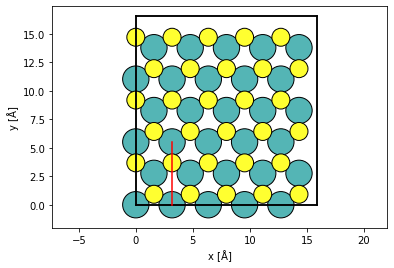

In [4]:
line_scan = abtem.LineScan(
    start=(potential.extent[0] / 5.0, 0.0),
    end=(potential.extent[0] / 5.0, potential.extent[1] / 3.0),
    gpts=50,
    endpoint=False,
)

fig, ax = abtem.show_atoms(atoms)
line_scan.add_to_axes(ax, color="r")

Calling `multislice` with the `LineScan` and `Potential` will result in the exit wave functions for every probe position along the scan, i.e. an ensemble of $50$ wave functions. 

In [5]:
exit_waves_line = probe.multislice(potential=potential, scan=line_scan)

## Applying detectors
In experiments, the exit wave functions are measured using detectors, and correspondingly *ab*TEM implements several detector types. For now, we shall focus on the `AnnularDetector`, which, depending on the choice of integration region, can represent the detector used in bright-field, medium- or high-angle annular dark-field microscopy, abbreviated BF, MAADF and HAADF, respectively.

Below we create a detector for BF, MAADF and HAADF by specifying the inner and outer radial integration angle in $\mathrm{mrad}$.

In [6]:
bright = abtem.AnnularDetector(inner=0, outer=30)
maadf = abtem.AnnularDetector(inner=50, outer=120)
haadf = abtem.AnnularDetector(inner=90, outer=200)

print(
    f"Maximum simulated scattering angle = {min(exit_waves_line.cutoff_angles):.1f} mrad"
)

Maximum simulated scattering angle = 278.0 mrad


We note that the maximum simulated angle ($278 \ \mathrm{mrad}$) is greater than the maximum detected angle ($200 \ \mathrm{mrad}$). An error will be thrown, if this is not true, in which case you need to increase the real-space `sampling` of the `Probe`.

The detector regions may be visualized using `show`, here the integrated region 

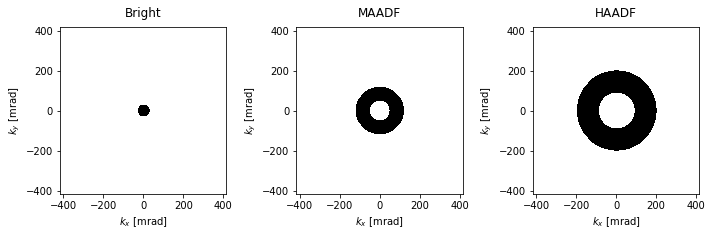

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

bright.show(exit_waves_line, title="Bright", ax=ax1, cmap="Greys")
maadf.show(exit_waves_line, title="MAADF", ax=ax2, cmap="Greys")
haadf.show(exit_waves_line, title="HAADF", ax=ax3, cmap="Greys")
plt.tight_layout()

The detectors can be applied by using `detect`. As we used a `LineScan`, the exit wave functions are converted to `RealSpaceLineProfiles`.

In [8]:
haadf.detect(exit_waves_line)

Scanning and detecting may be combined when using `scan` with a list of detectors producing a list of `LineProfiles` with an entry corresponding to each detector.

In [9]:
all_detectors = [bright, maadf, haadf]

measurements = probe.scan(potential, detectors=all_detectors, scan=line_scan).compute();

[########################################] | 100% Completed | 5.77 sms


We show the `RealSpaceLineProfiles` below.

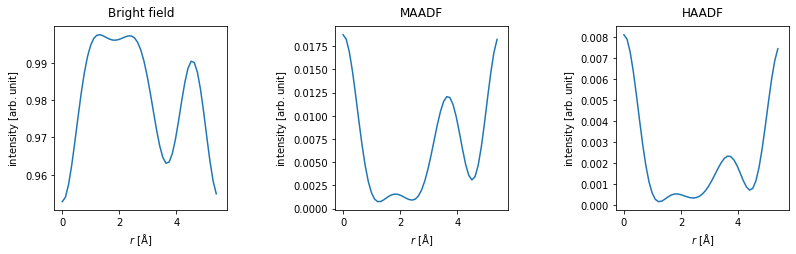

In [10]:
measurements = abtem.stack(measurements, ("Bright field", "MAADF", "HAADF"))

visualization = measurements.show(explode=True, common_scale=False, figsize=(12, 3))

visualization.set_axes_padding([1.5, 0])

The probe is normalized to integrate to $1$ in Fourier space. Looking at the plot showing the bright field intensity, we can conclude that there is almost no scattering in the hexagon centers (i.e. for $r\sim 2 \mathrm{Å}$), while $\sim5 \%$ of the electrons scatter outside the bright-field disk when the probe is placed directly on the atoms (i.e. for $r = 0$).

## STEM simulations

We perform typical STEM simulations using a `GridScan` much the same as we did with the `LineScan` above. We define a scan across a periodic unit of the potential using fractional coordinates with the alternate initializer `from_fractional_coordinates`. The probe step size (or `sampling`) is set to the [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency) of the probe contrast transfer function.

In [11]:
sampling = probe.aperture.nyquist_sampling
print(f"Nyquist sampling = {sampling:.3f} Å/pixel")

Nyquist sampling = 0.522 Å/pixel


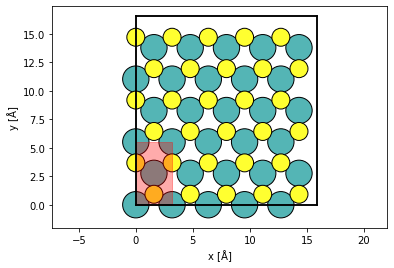

In [12]:
grid_scan = abtem.GridScan.from_fractional_coordinates(
    potential, start=[0, 0], end=[1 / 5, 1 / 3], sampling=sampling
)

fig, ax = abtem.show_atoms(atoms)
grid_scan.add_to_plot(ax)

We set up the STEM simulation, which will result in a list of `Images`. 

In [13]:
measurements = probe.scan(potential, scan=grid_scan, detectors=all_detectors)
measurements

It is convenient to stack the measurements into a single `Images` object, so that they can be saved as a single file.

In [14]:
measurements = abtem.stack(measurements, ("BF", "MAADF", "HAADF"))

We write the `Images` to disk, which will trigger the computations to run (this will take around 20 s).

In [15]:
measurements.to_zarr("mos2_stem_measurements.zarr");

We show the resulting `Images` below.

In [16]:
imported_measurements = abtem.from_zarr("mos2_stem_measurements.zarr").compute()

[########################################] | 100% Completed | 116.09 ms


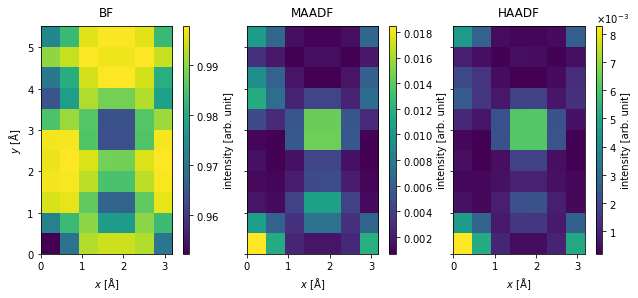

In [17]:
imported_measurements.show(explode=True, cbar=True, figsize=(10, 5));

## Post-processing STEM measurements

STEM simulations usually requires some post-processing, and we apply the most common steps below.

### Interpolation

We saved a lot of computational time by scanning at the Nyquist frequency, but the result is quite pixelated. To address this, we interpolate the images to a sampling of $0.1 \ \mathrm{Å / pixel}$. *ab*TEM's default interpolation algorithm is Fourier-space padding, but spline interpolation is also available, which is more appropriate if the image in non-periodic.

In [18]:
interpolated_measurement = imported_measurements.interpolate(sampling=0.1).compute()

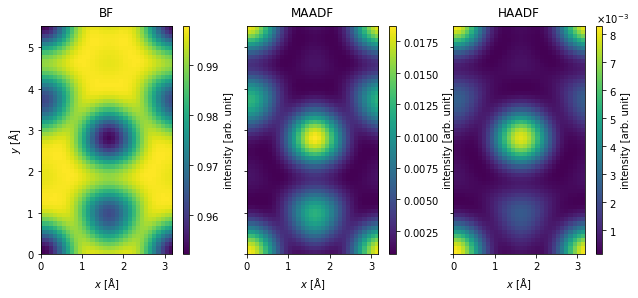

In [19]:
interpolated_measurement.show(explode=True, cbar=True, figsize=(10, 5));

### Blurring

A finite Gaussian-shaped source will result in a blurring of the image. Vibrations and other instabilities may further contribute to the blur. We apply a Gaussian blur with a standard deviation of $0.5 \ \mathrm{Å}$ (corresponding to a source of approximately that size).

```{seealso}
We are not including partial temporal incoherence here. See our [tutorial on partial coherence](../tutorials/partial_coherence.ipynb) in STEM simulations for a detailed description, as well as a more rigorous treatment of partial spatial coherence using the contrast transfer function.
```

In [20]:
blurred_measurement = interpolated_measurement.gaussian_filter(0.5).compute()

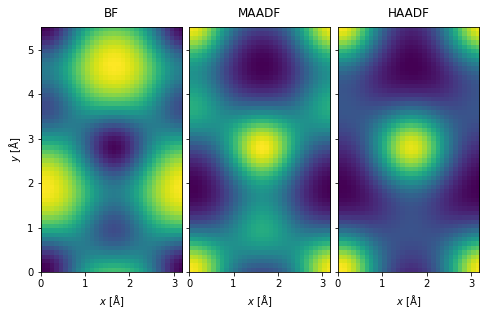

In [21]:
blurred_measurement.show(explode=True, figsize=(12, 4));

### Noise

Simulations such as the above corresponds to the limit of an infinite electron dose. An image with a finite electron dose will contain [shot noise](https://en.wikipedia.org/wiki/Shot_noise). We can get a random sample for a finite dose by drawing random numbers from a Poisson distribution for every pixel. The Poisson distribution has a mean of

$$
    \lambda = \mathrm{area \ per \ pixel} \times \mathrm{dose \ per \ area} \times \mathrm{intensity} \quad ,
$$

where it is assumed that intensity of the Fourier space probe is normalized to integrate to $1$.

Before applying the noise, we tile the images to get better statistics.

In [22]:
tiled_measurement = blurred_measurement.tile((7, 4))

We apply Poisson noise corresponding a dose per area of $10^5 \ \mathrm{e}^- / \mathrm{Å}^2$.

In [23]:
noisy_measurement = tiled_measurement.poisson_noise(dose_per_area=1e5, seed=100).compute()

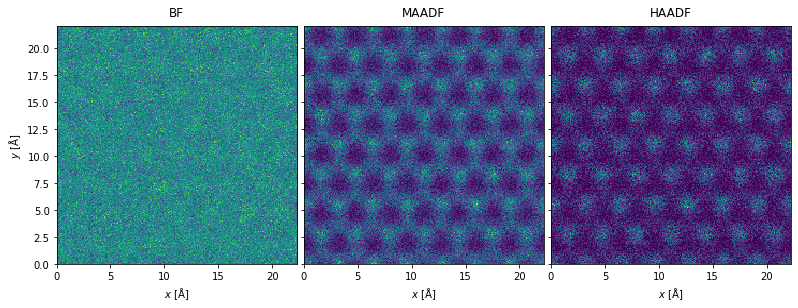

In [24]:
noisy_measurement.show(explode=True, figsize=(12, 4));

Poisson noise is generally the most important source of noise in STEM images, but scan noise due to vibrations and voltage instabilities in the scan coils may also be significant{cite}`jones_scan_noise`, see `abtem.measure.apply_scan_noise`. For completeness, we note that thermal noise in the detector material may also contribute. 

## Detectors

Many kinds of detectors are widely used in STEM, and *ab*TEM accordingly implements the following detector types:

* `AnnularDetector`: Integrates diffraction patterns between two scattering angles. Used for BF, MAADF and HAADF.
* `FlexibleAnnularDetector`: Bins diffraction patterns in radial regions. Used for BF, MAADF and HAADF, allowing the angles to be adapted after the simulation.
* `SegmentedDetector`: Bins diffraction patterns in radial and azimuthal regions. Used for differential phase constrast STEM (DPC-STEM).
* `PixelatedDetector`: Detects full diffraction patterns. Used for 4D-STEM.
* `WavesDetector`: Detects the full wave function. Mostly for internal use.

The `AnnularDetector` was introduced in the preceding section, and in the following the rest of the detectors are discussed.

### `FlexibleAnnularDetector`

The `FlexibleAnnularDetector` radially bins the diffraction pattern, thus allowing us to choose the integration limits after running the simulation. Compared to saving the full diffraction pattern, the advantage of this detector is its significantly reduced memory or disk usage. The `FlexibleAnnularDetector` is the default detector for STEM simulations in *ab*TEM.

Here, we create a detector with a spacing between detector bins of $1 \ \mathrm{mrad}$.

In [25]:
flexible_detector = abtem.FlexibleAnnularDetector(step_size=1)

We run the scanned multislice simulations.

In [26]:
flexible_measurement = probe.scan(
    potential, scan=grid_scan, detectors=flexible_detector
)

We can compute *before* choosing the integration limits

In [27]:
flexible_measurement.compute()

[########################################] | 100% Completed | 5.76 sms


The result is `PolarMeasurements`; the measurement values are binned on a uniform polar grid, where two base axes represents the radial and azimuthal directions, respectively. In this case, there is only a single azimuthal coordinate.

In [28]:
flexible_measurement.axes_metadata

type        label                             coordinates
----------  --------------------------------  --------------------
ScanAxis    x [Å]                             0.00 0.45 ... 2.73
ScanAxis    y [Å]                             0.00 0.50 ... 5.01
LinearAxis  Radial scattering angle [mrad]    0.00 1.00 ... 276.00
LinearAxis  Azimuthal scattering angle [rad]  0.00

We can reproduce the BF, MAADF and HAADF measurements obtained from the `AnnularDetector` above by integrating the `PolarMeasurements`.

In [29]:
stacked = abtem.stack(
    [
        flexible_measurement.integrate_radial(0, 30),
        flexible_measurement.integrate_radial(50, 120),
        flexible_measurement.integrate_radial(90, 200),
    ],
    ("BF", "MAADF", "HAADF"),
)

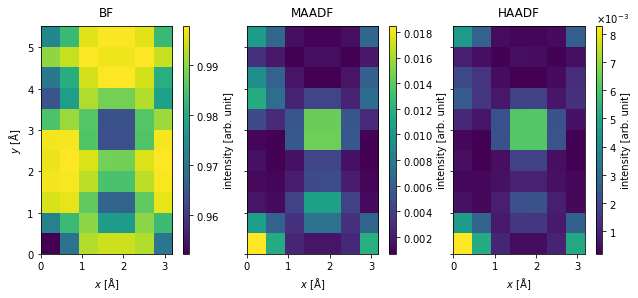

In [30]:
stacked.show(explode=True, cbar=True, figsize=(10, 5));

### `SegmentedDetector`

The `SegmentedDetector` covers an annular region and is partitioned into several detector regions forming radial and azimuthal segments. 

Below we define a `SegmentedDetector` covering the annular region between $40$ and $80 \ \mathrm{mrad}$. It is divided 
into $2$ radial regions, each of which are divided into $4$ azimuthal regions. The detector regions are rotated by $45 \ \mathrm{deg.}$ with respect to the cartesian axes.

In [31]:
segmented_detector = abtem.SegmentedDetector(
    inner=40, outer=80, nbins_radial=2, nbins_azimuthal=4, rotation=np.pi / 4
)

We may illustrate the detector regions below using a polar plot.

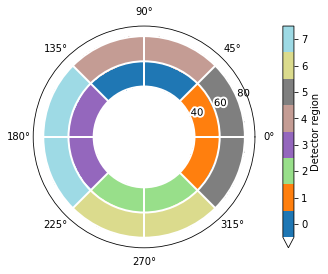

In [32]:
segmented_detector.show(radial_ticks=[40, 60, 80], figsize=(10, 4));

We then run the scanned multislice simulation. The resulting `PolarMeasurement` is 4D, the first two (ensemble) axes representing the scan directions and the last two (base) axes represents the radial and azimuthal bin axes.

In [33]:
segmented_measurement = probe.scan(
    potential, scan=grid_scan, detectors=segmented_detector
)
segmented_measurement.axes_metadata

type        label                             coordinates
----------  --------------------------------  ------------------
ScanAxis    x [Å]                             0.00 0.45 ... 2.73
ScanAxis    y [Å]                             0.00 0.50 ... 5.01
LinearAxis  Radial scattering angle [mrad]    40.00 60.00
LinearAxis  Azimuthal scattering angle [rad]  0.79 2.36 ... 5.50

In [34]:
segmented_measurement.compute()

[########################################] | 100% Completed | 5.67 sms


We show the detected intensities for scan position `(1, 1)` on a polar plot. This scan position is offset from the atom at $(x,y) = (0,0)$ at an angle of $~ 45 \ \mathrm{deg.}$, hence the electric field attracts the electrons towards the opposite direction, i.e. the detector segments near $\sim 225 \ \mathrm{deg.}$

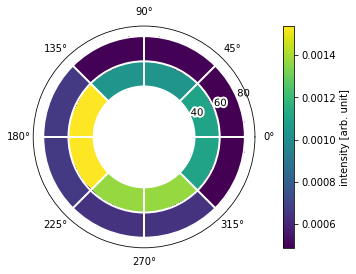

In [35]:
segmented_measurement[1, 1].show(radial_ticks=[40, 60, 80], cbar=True, figsize=(10, 4));

Below we calculate the differential signals in the $x$- and $y$-directions. The differential signal in the $x$-direction is calculated as the difference between detector regions 1 and 3, for the $y$-direction it is the difference between detector regions 0 and 2.

In [36]:
differential = segmented_measurement.differentials(
    direction_1=[(3,), (1,)],
    direction_2=[(2,), (0,)],
    return_complex=True,
)

The differential signal is returned as complex `Images`, where the real and imaginary parts correspond to the $x$- and $y$-direction, respectively.

To show the results, we first interpolate and tile. The different representations of the complex parts are stacked to show an exploded plot.

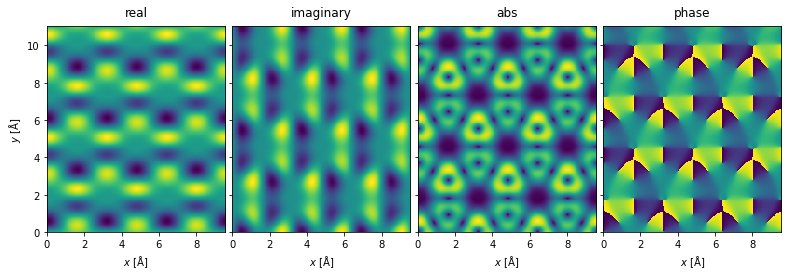

In [37]:
interpolated_differential = (
    differential.interpolate(0.05).gaussian_filter(0.3).tile((3, 2))
)

abtem.stack(
    [
        interpolated_differential.real(),
        interpolated_differential.imag(),
        interpolated_differential.abs(),
        interpolated_differential.phase(),
    ],
    ("real", "imaginary", "abs", "phase"),
).show(explode=True, figsize=(12, 4));

We can also display the complex `Images` using domain coloring.

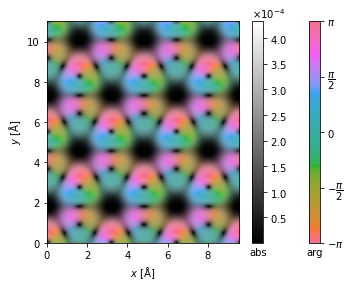

In [38]:
interpolated_differential.show(cbar=True);

### `PixelatedDetector`

The `PixelatedDetector` records the diffraction patterns for every probe position. Hence, a 2D scan with this detector results in a four-dimensional dataset. The 4D datasets can be used to reconstruct the results of all the other detector geometries. 

Below we create a `PixelatedDetector` saving the diffraction patterns up to $200 \ \mathrm{mrad}$ and run the scanned multislice algorithm.

In [39]:
pixelated_detector = abtem.PixelatedDetector(max_angle=200)

pixelated_measurements = probe.scan(
    potential,
    scan=grid_scan,
    detectors=pixelated_detector,
)
pixelated_measurements.compute()

[########################################] | 100% Completed | 5.66 sms


We show the detected intensities for scan position `(1, 1)` up to $80 \ \mathrm{mrad}$. Since the diffraction pattern is often dominated by the direct disk, it is sometimes preferable to block the direct intensity.

We can make the same observation, as we did for the `SegmentedDetector`: the electrons are attracted in the direction of the atomic potential.

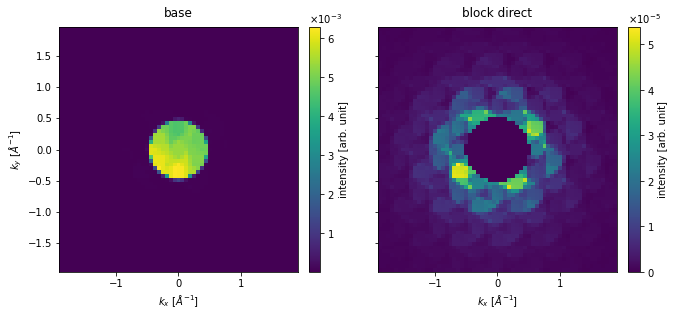

In [40]:
cropped_diffraction_pattern = pixelated_measurements[1, 1].crop(max_angle=80)

abtem.stack(
    [
        cropped_diffraction_pattern,
        cropped_diffraction_pattern.block_direct(),
    ],
    ("base", "block direct"),
).show(explode=True, figsize=(12, 4), cbar=True);

As an alternative to blocking the direct disk, we can show the diffraction pattern on a power scale to relatively enhance the low intensities.

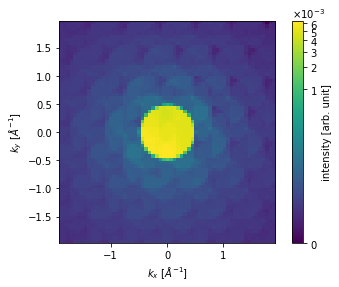

In [41]:
cropped_diffraction_pattern.show(power=.2, cbar=True);

We can obtain the annular integrated measurements from the diffraction patterns by integrating radially as shown below.

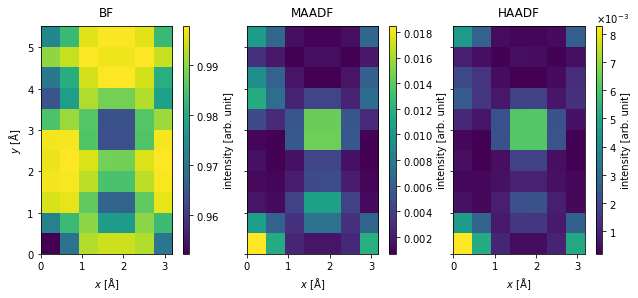

In [42]:
stacked = abtem.stack(
    [
        pixelated_measurements.integrate_radial(0, 30),
        pixelated_measurements.integrate_radial(50, 120),
        pixelated_measurements.integrate_radial(90, 200),
    ],
    ("BF", "MAADF", "HAADF"),
)

stacked.show(explode=True, cbar=True, figsize=(10, 5));

The center of mass, $\vec{I}_{com}(\vec{r}_p)$, of the diffraction pattern at a probe position, $\vec{r}_p$, may be calculated as

$$
    \vec{I}_{com}(\vec{r}_p) = \int \hat{I}(\vec{k}, \vec{r}_p) \vec{k} d^2\vec{k} \quad ,
$$

where $\hat{I}(\vec{k})$ is a diffraction pattern intensity. Doing this for every diffraction pattern, we obtain the image shown below. The center of mass is returned as complex `Images`, where the real and imaginary parts correspond to the $x$- and $y$-direction, respectively. We set `units="reciprocal"`, hence each complex component is in units of $\mathrm{Å}^{-1}$.

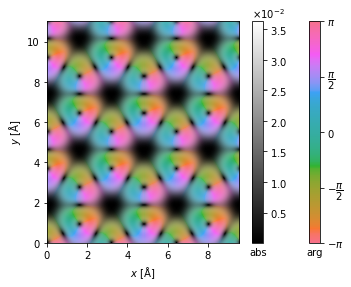

In [43]:
center_of_mass = pixelated_measurements.center_of_mass(units="1/Å")

interpolated_center_of_mass = center_of_mass.interpolate(0.05).tile((3, 2))

interpolated_center_of_mass.show(cbar=True);

It may be shown{cite}`lazic_idpc`, in the weak-phase approximation, that by integrating $\vec{I}_{com}(\vec{r}_p)$, we can obtain the phase change of the exit wave, $\phi(\vec{r_p})$, cross-correlated with the probe intensity

$$
\vec{I}_{iCOM}(\vec{r}_p) = \frac{1}{2\pi} \left[\|\psi_0(\vec{r})\|^2 \star \phi(\vec{r})\right](\vec{r}_p) \quad .
$$

This is the so-called integrated center of mass. We can calculate this using the `integrate_gradient` method, which assumes a complex `Image`.

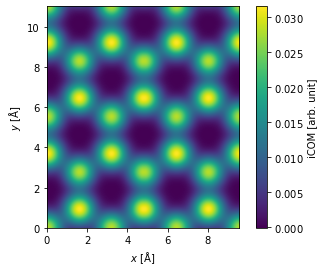

In [44]:
integrated_gradient = center_of_mass.integrate_gradient()

interpolated_integrated_gradient = integrated_gradient.interpolate(0.05).tile((3, 2))

interpolated_integrated_gradient.show(cbar=True);